# Monthly Crime Distribution and Variance

## Imports and load data

In [1]:
import pickle
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import pandas as pd
from scipy import stats
pd.set_option('display.max_columns', None)

In [2]:
with open("/home/pgrylls/Documents/RSG/AI-CJS/.__scratch__/ai_cjs/.__scratch__/data/real_crime_profiles/lat_long_51.5081_-0.1469/1232019/pol_db.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
grid_prof = np.load("/home/pgrylls/Documents/RSG/AI-CJS/.__scratch__/ai_cjs/.__scratch__/data/real_crime_profiles/lat_long_51.5081_-0.1469/1232019/grid_profile.npy")

## Full list of crimes extracted from Police API

In [4]:
display(data)

,category,month,location_latitude,location_longitude
0,burglary,2019-01,51.508528,-0.144481
1,criminal-damage-arson,2019-01,51.508528,-0.144481
2,other-theft,2019-01,51.508528,-0.144481
3,other-theft,2019-01,51.508528,-0.144481
4,other-theft,2019-01,51.508539,-0.145215
...,...,...,...,...
5,robbery,2019-03,51.534061,-0.102566
6,vehicle-crime,2019-03,51.534061,-0.102566
7,violent-crime,2019-03,51.533584,-0.104172
8,violent-crime,2019-03,51.533584,-0.104172


In [5]:
len(data)

20787

## Calculate mean and standard deviation
#### Firstly for each cell over the whole year
#### Then for the whole crime in each month

In [6]:
mean = grid_prof.mean(axis=0)
std = grid_prof.std(axis=0)
mean_std_month = []
for i in grid_prof:
    mean_std_month.append([i.mean(), i.std()])

#### Size of grid

In [7]:
grid_prof.shape

(3, 20, 20)

#### Total crimes over time

In [8]:
grid_prof.sum()

20787

#### Crimes in an average month

In [9]:
mean.sum()

6929.0

## Show the variation from month to month for each grid cell

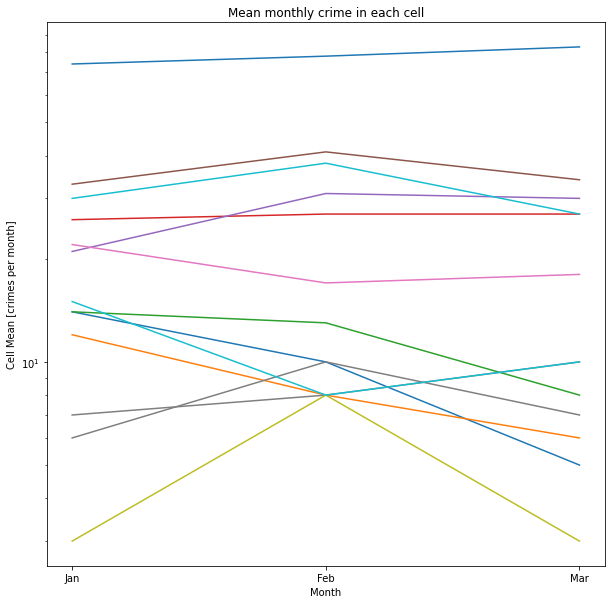

In [10]:
x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_lables = [x_labels[i%12] for i in range(grid_prof.shape[0])]
x = np.arange(1, grid_prof.shape[0]+1)
plt.figure(figsize=(10, 10))
for i in range(grid_prof.shape[1]):
    if i % grid_prof.shape[1] == 0:
        for j in range(grid_prof.shape[2]):
            plt.plot(x, grid_prof[:,i,j])
plt.title("Mean monthly crime in each cell")
plt.xlabel("Month")
plt.xticks(x, labels=x_labels)
plt.ylabel("Cell Mean [crimes per month]")
plt.yscale('log')
plt.show()

## Show the relationship between mean crime and the standard deviation for each cell

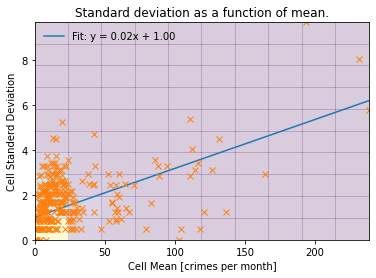

In [18]:
m, c = np.polyfit(mean.flatten(), std.flatten(), 1)
x = np.arange(0,np.max(mean.flatten()))
plt.plot(x, m*x + c, label= "Fit: y = {:.2f}x + {:.2f}".format(m, c))
plt.plot(mean.flatten(), std.flatten(), "x")
plt.hist2d(mean.flatten(), std.flatten(), alpha = 0.2)
plt.legend(frameon = False)
plt.title("Standard deviation as a function of mean.")
plt.xlabel("Cell Mean [crimes per month]")
plt.ylabel("Cell Standerd Deviation")
plt.show()

## Show the probability that a given cell has a given mean using a normilsed histogram

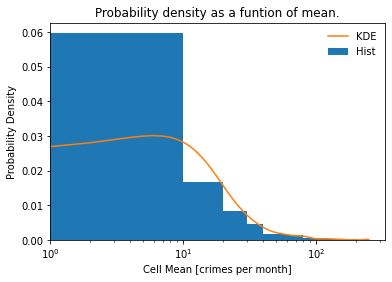

In [12]:
bins = np.concatenate((np.arange(0,50,10),np.arange(60,120,20),np.arange(150,300,50)))
plt.hist(mean.flatten(), bins = bins, density = True, label = "Hist")
x = np.arange(0,250)
kde = stats.gaussian_kde(mean.flatten())
plt.plot(x, kde(x), label = "KDE")
plt.title("Probability density as a funtion of mean.")
plt.xlabel("Cell Mean [crimes per month]")
plt.ylabel("Probability Density")
plt.xscale('log')
plt.xlim(1)
plt.legend(frameon=False)
plt.show()

### Test that resampling and then generating x crimes per cell retrieves the KDE

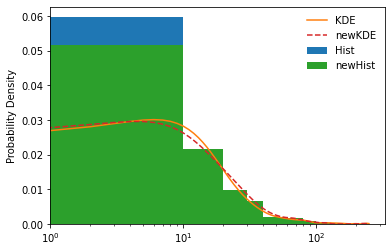

Number of crimes from resample in one month (one pass):  6753.5 106.27205653416142


In [13]:
# Original Plots
hist_bins = np.concatenate((np.arange(0,50,10),np.arange(60,120,20),np.arange(150,300,50)))
plt.hist(mean.flatten(), bins = hist_bins, density = True, label = "Hist")
x = np.arange(0,250)
plt.plot(x, kde(x), label = "KDE")

# Resampling
cells_4_sample = grid_prof.shape[1]*grid_prof.shape[2]
mth_resample_means = kde.resample(cells_4_sample).astype(int).flatten()
mth_resample_means[mth_resample_means<0]=0
mth_resample_stdev = m*mth_resample_means + c

#creating the new crimes from the resample
grid_crimes = np.concatenate([np.full(number, ix) if number > 0
                              else np.full(0, ix)
                              for ix, number in
                              enumerate(np.random.normal(mth_resample_means,
                                                         mth_resample_stdev).round().astype(int))
                              ])

freq, _bins = np.histogram(grid_crimes, bins = np.arange(0, cells_4_sample, 1).astype(int))


newkde = stats.gaussian_kde(freq)
plt.hist(mth_resample_means, bins = hist_bins, density = True, label = "newHist")
plt.plot(x, newkde(x), "--", label = "newKDE")
plt.ylabel("Probability Density")
plt.xscale('log')
plt.xlim(1)
plt.legend(frameon=False)
plt.show()

grid_crimes_size = []
for i in range(100):
    #creating the new crimes from the resample
    grid_crimes = np.concatenate([np.full(number, ix) if number > 0
                                  else np.full(0, ix)
                                  for ix, number in
                                  enumerate(np.random.normal(mth_resample_means,
                                                             mth_resample_stdev).round().astype(int))
                                  ])
    grid_crimes_size.append(grid_crimes.size)

print("Number of crimes from resample in one month (one pass): ", np.mean(grid_crimes_size), np.std(grid_crimes_size))

### Test how we retrieve this using a day by day model

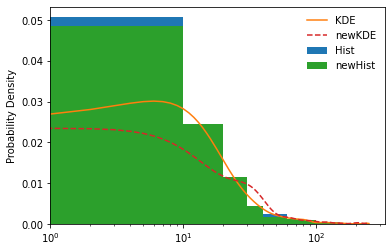

Number of crimes from resample in one month (thirty passes):  7870.12 36.36352018163257


In [23]:
# Original Plots
hist_bins = np.concatenate((np.arange(0,50,10),np.arange(60,120,20),np.arange(150,300,50)))
plt.hist(mean.flatten(), bins = hist_bins, density = True, label = "Hist")
x = np.arange(0,250)
plt.plot(x, kde(x), label = "KDE")

# Resampling
cells_4_sample = grid_prof.shape[1]*grid_prof.shape[2]
mth_resample_means = kde.resample(cells_4_sample).astype(int).flatten()
mth_resample_means[mth_resample_means<0]=0
mth_resample_stdev = m*mth_resample_means + c

#creating the new crimes from the resample
grid_crimes = []
for i in range(30):
    grid_crimes_day = np.concatenate([np.full(number, ix) if number > 0
                                  else np.full(0, ix)
                                  for ix, number in
                                  enumerate(np.divide(np.random.normal(mth_resample_means,
                                                             mth_resample_stdev),30).round().astype(int))
                                  ])
    grid_crimes.append(grid_crimes_day)
grid_crimes = np.concatenate(grid_crimes)
freq, _bins = np.histogram(grid_crimes, bins = np.arange(0, cells_4_sample, 1).astype(int))
newkde = stats.gaussian_kde(freq)
plt.hist(mth_resample_means, bins = hist_bins, density = True, label = "newHist")
plt.plot(x, newkde(x), "--", label = "newKDE")
plt.ylabel("Probability Density")
plt.xscale('log')
plt.xlim(1)
plt.legend(frameon=False)
plt.show()

grid_crimes_size = []
for i in range(100):
    grid_crimes = []
    for i in range(30):
        grid_crimes_day = np.concatenate([np.full(np.max([number.round().astype(int), 1]), ix) 
                                          if (number > np.random.random())
                                          else np.full(0, ix)
                                          for ix, number in
                                          enumerate(np.divide(np.random.normal(mth_resample_means, 
                                                                               mth_resample_stdev),30))
                                         ])
        grid_crimes.append(grid_crimes_day)
    grid_crimes = np.concatenate(grid_crimes)
    grid_crimes_size.append(grid_crimes.size)

print("Number of crimes from resample in one month (thirty passes): ", np.mean(grid_crimes_size), np.std(grid_crimes_size))

#### Retrieving original statistics from resample

In [19]:
cells_4_sample = grid_prof.shape[1]*grid_prof.shape[2]
grid_crimes_month = []
for i in range(grid_prof.shape[0]):
    #creating the new crimes from the resample
    grid_crimes = []
    for i in range(30):
        grid_crimes_day = np.concatenate([np.full(np.max([number.round().astype(int), 1]), ix) 
                                          if (number > np.random.random())
                                          else np.full(0, ix)
                                          for ix, number in
                                          enumerate(np.divide(np.random.normal(mth_resample_means, 
                                                                               mth_resample_stdev),30))
                                         ])
        grid_crimes.append(grid_crimes_day)
    grid_crimes = np.concatenate(grid_crimes)
    freq, _bins = np.histogram(grid_crimes, bins = np.arange(0, cells_4_sample+1, 1).astype(int))
    grid_crimes_month.append(freq.reshape(grid_prof.shape[1], grid_prof.shape[2]))


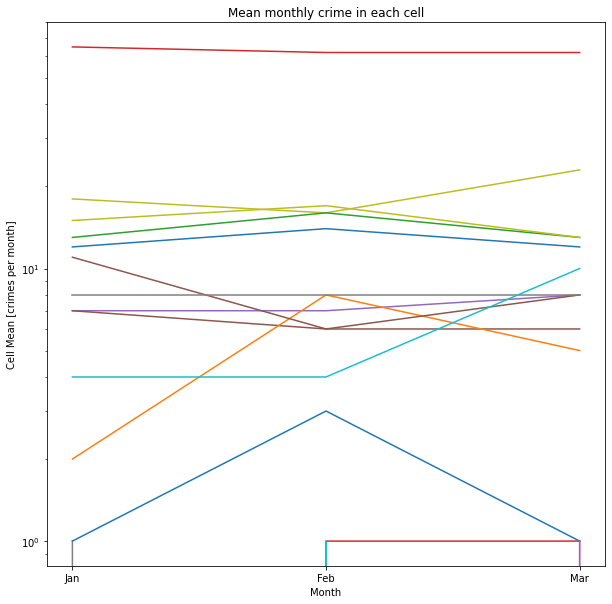

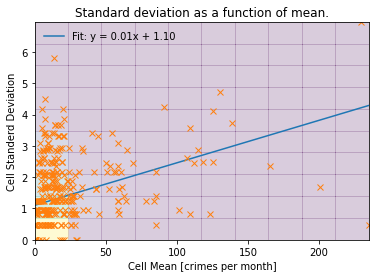

In [20]:
grid_prof = np.array(grid_crimes_month)
mean = grid_prof.mean(axis=0)
std = grid_prof.std(axis=0)
mean_std_month = []
for i in grid_prof:
    mean_std_month.append([i.mean(), i.std()])
    
x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_lables = [x_labels[i%12] for i in range(grid_prof.shape[0])]
x = np.arange(1, grid_prof.shape[0]+1)
plt.figure(figsize=(10, 10))
for i in range(grid_prof.shape[1]):
    if i % grid_prof.shape[1] == 0:
        for j in range(grid_prof.shape[2]):
            plt.plot(x, grid_prof[:,i,j])
plt.title("Mean monthly crime in each cell")
plt.xlabel("Month")
plt.xticks(x, labels=x_labels)
plt.ylabel("Cell Mean [crimes per month]")
plt.yscale('log')
plt.show()

m, c = np.polyfit(mean.flatten(), std.flatten(), 1)
x = np.arange(0,np.max(mean.flatten()))
plt.plot(x, m*x + c, label= "Fit: y = {:.2f}x + {:.2f}".format(m, c))
plt.plot(mean.flatten(), std.flatten(), "x")
plt.hist2d(mean.flatten(), std.flatten(), alpha = 0.2)
plt.legend(frameon = False)
plt.title("Standard deviation as a function of mean.")
plt.xlabel("Cell Mean [crimes per month]")
plt.ylabel("Cell Standerd Deviation")
plt.show()

In [17]:
np.max?